<a href="https://colab.research.google.com/github/arulagarwal/Dynamic-Image-Resizing-using-Seam-Carving/blob/master/Seam_Carving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#@title Import required packages
import sys
from tqdm import trange
import numpy as np
from imageio import imread, imwrite
from scipy.ndimage.filters import convolve
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import Image


In [ ]:
#@title Define Processing Functions
def calc_energy(img):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_dv = np.stack([filter_dv] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.absolute(convolve(img, filter_du)) + np.absolute(convolve(img, filter_dv))

    # We sum the energies in the red, green, and blue channels
    energy_map = convolved.sum(axis=2)

    return energy_map

def crop_c(img, scale_c):
    r, c, _ = img.shape
    new_c = int(scale_c * c)

    for i in trange(c - new_c):
        img = carve_column(img)

    return img

def crop_r(img, scale_r):
    img = np.rot90(img, 1, (0, 1))
    img = crop_c(img, scale_r)
    img = np.rot90(img, 3, (0, 1))
    return img

def carve_column(img):
    r, c, _ = img.shape

    M, backtrack = minimum_seam(img)
    mask = np.ones((r, c), dtype=np.bool)

    j = np.argmin(M[-1])
    for i in reversed(range(r)):
        mask[i, j] = False
        j = backtrack[i, j]

    mask = np.stack([mask] * 3, axis=2)
    img = img[mask].reshape((r, c - 1, 3))
    return img

def minimum_seam(img):
    r, c, _ = img.shape
    energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=np.int)

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index a -1
            if j == 0:
                idx = np.argmin(M[i-1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i-1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack



In [ ]:
#@title Add Image
from google.colab import files
#upload file
uploaded = files.upload()

Saving pietro-de-grandi-329892-unsplash.jpg to pietro-de-grandi-329892-unsplash.jpg


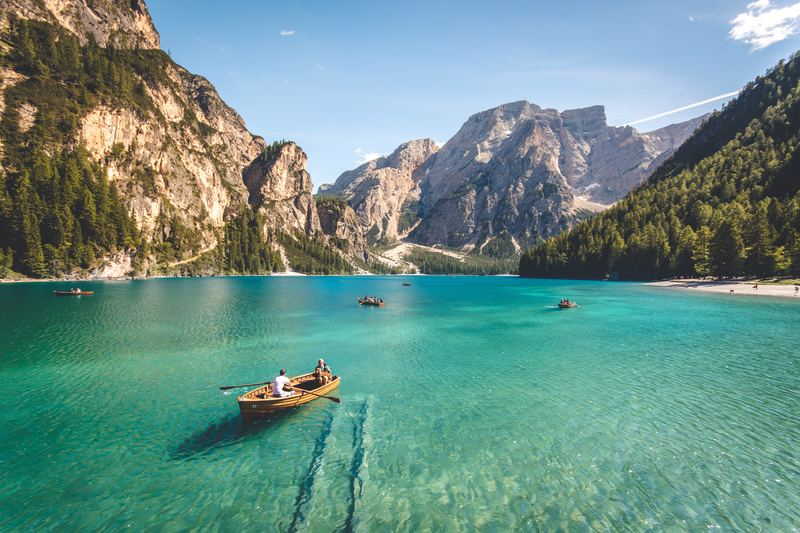

In [22]:
#@title Input Image
Image(filename='/content/pietro-de-grandi-329892-unsplash.jpg') 

In [ ]:
def main():

    which_axis = 'r'        #add axis
    scale = float('0.5')    #add scale
    in_filename = '/content/pietro-de-grandi-329892-unsplash.jpg' #add file path
    out_filename = '/content/otput.jpg' #add desired output file path and name

    img = imread(in_filename)

    if which_axis == 'r':
        out = crop_r(img, scale)
    elif which_axis == 'c':
        out = crop_c(img, scale)
    else:
        print('usage: carver.py <r/c> <scale> <image_in> <image_out>', file=sys.stderr)
        sys.exit(1)
    
    imwrite(out_filename, out)

if __name__ == '__main__':
    main()

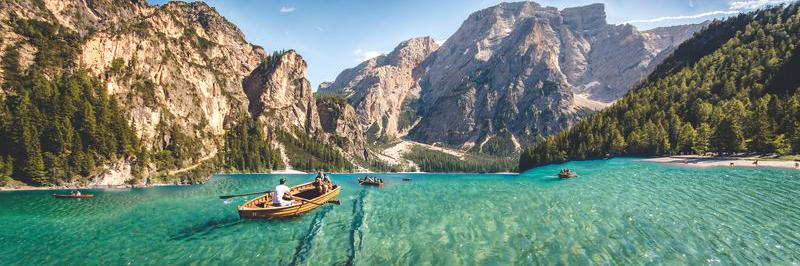

In [23]:
#@title Output Image
Image(filename='/content/otput.jpg') 